In [356]:
import torch
import numpy as np
import os
import pandas as pd
import time
from os import listdir
import functools
import pickle
import math
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# FUGUE STATE 
### Conditional Generative Adversarial Network for Multi-Instrument Song Creation
#### Alexander Rusnak and Nick Arnold

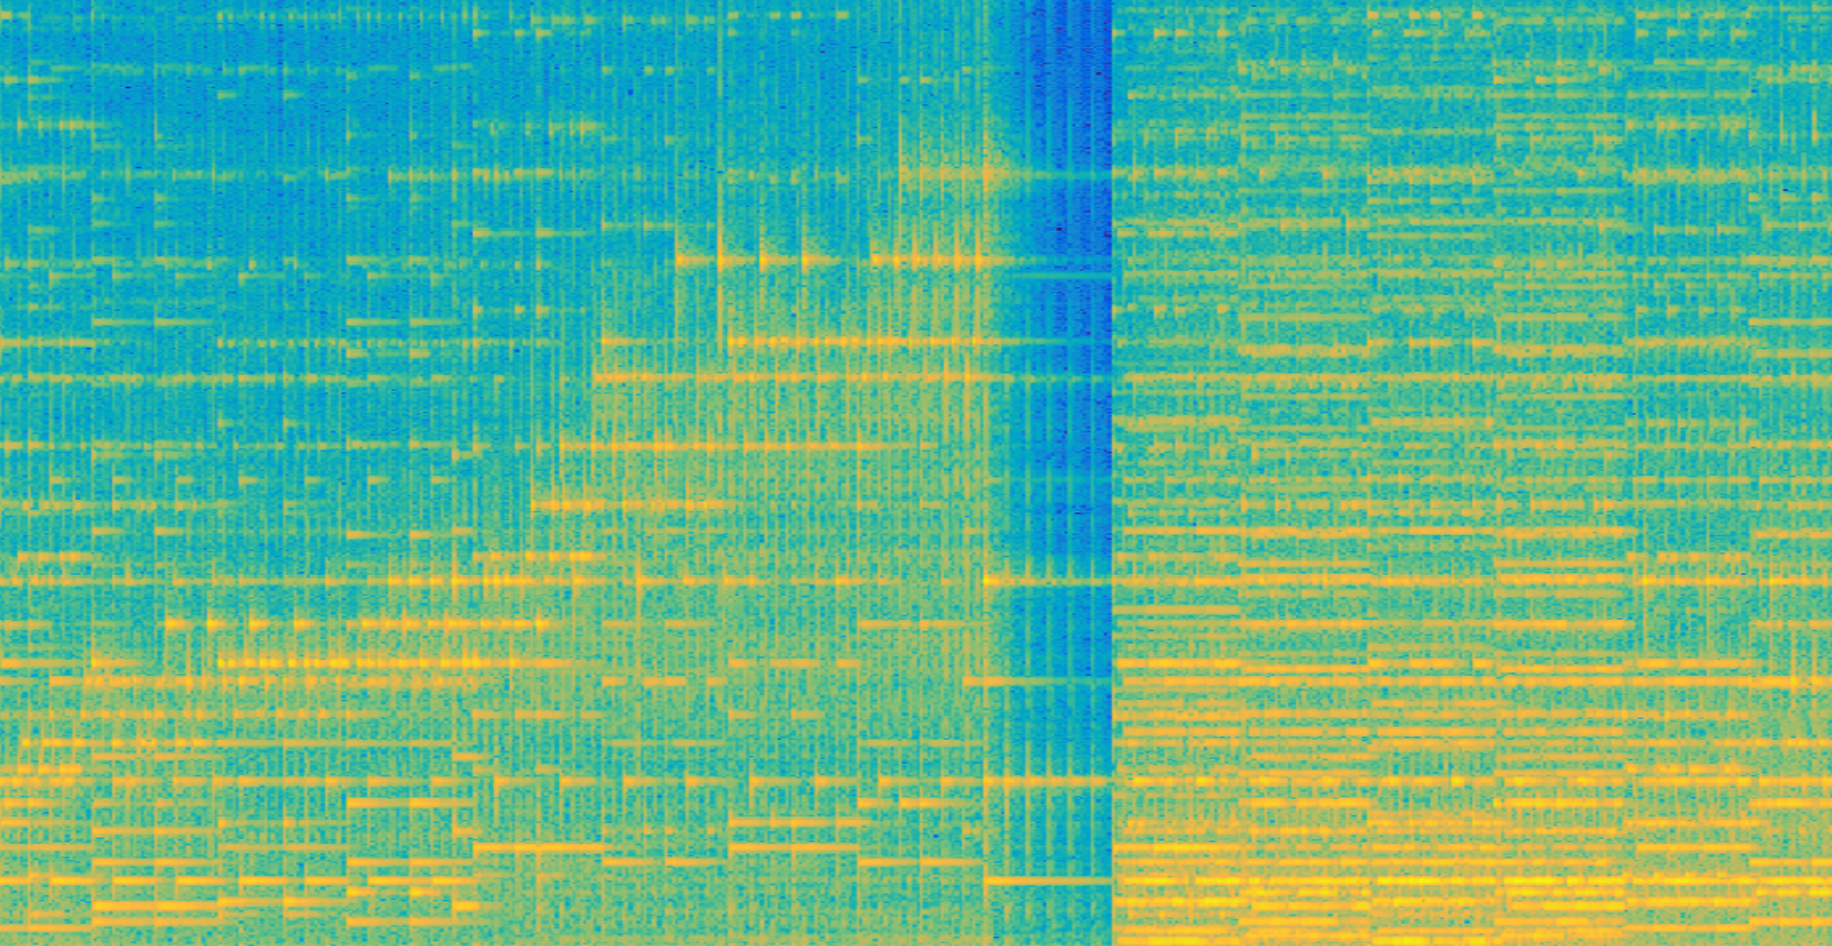

In [345]:
Image(filename='ExampleData/PianoSpec.png') 

## Example of original MIDI data encoding 
#### 4 tracks (Drums, Piano, Guitar, and Bass) -> Taken from songs, more specific instruments clustered into these 4 subcategories
#### For each instrument there is a note stream with the note start, note end, pitch, and velocity. 
#### Timing for note streams is not consistent between instruments in a song

#### Don't run the below cells, just for example

In [76]:
# this cell won't run if you download this from git because I'm not including this file
house = pd.read_pickle('ThiccDatasets/houseArr.pkl')

In [350]:
# example drum stream for song 
house[0][0]

,0,1,2,3
0,0.065016,0.120744,39,69
1,0.218267,0.273995,39,78
2,0.227555,0.278639,69,10
3,0.264707,0.278639,69,10
4,0.227555,0.283283,82,1
...,...,...,...,...
832,29.633766,29.693622,40,101
833,29.633766,29.693622,69,56
834,29.638926,29.698266,65,115
835,29.777214,29.835006,65,127


In [354]:
# example piano stream -> notice different in length of dataframes, substantially more drum notes
house[1][0]

,0,1,2,3
0,0.083592,0.130032,50,121
1,0.083592,0.195047,62,127
2,0.371519,0.487618,65,126
3,0.371519,0.501550,53,126
4,0.654801,0.756969,51,127
...,...,...,...,...
72,27.255531,27.564614,72,105
73,27.589898,28.183812,71,105
74,28.207548,28.755538,71,104
75,28.778758,29.326748,72,104


In [157]:
# Flattens time of an instrument into a single series for standardization
def flat_time(instrument):
    return instrument[0].append(instrument[1]).to_numpy()

In [362]:
# standardizes the time scale between 0 and 1 for each song and combines the instruments into a single dataframe with 
# a consistent index of time. Notice this approach makes the absolute 'length' of every song the same, the time values only
# represent the relationship between the note spacing. This makes it easier for the model to learn / allows us to modulate 
# the tempo mroe easily after generation.

def standardize_time(piano, bass, guitar, drums):
    # Flatten time dimensions
    pTime = flat_time(piano)
    bTime = flat_time(bass)
    gTime = flat_time(guitar)
    dTime = flat_time(drums)
    # Join times together
    joinedTime = np.concatenate((pTime, bTime, gTime, dTime), axis=None).reshape(-1,1)
    # MinMax scale the time between all the instruments into a consistent span
    scaler = MinMaxScaler()
    scaler.fit(joinedTime)
    scaledTime = scaler.transform(joinedTime)

    # Each of these re-seperates the now scaled time by instrument, renames the columns, and sets it to 3 decimal points
    pScaled = np.around(scaledTime[:len(pTime)].reshape(2,len(piano)).astype('float32'), decimals=3)
    pScaled = pd.concat([pd.DataFrame(pScaled.T), piano[[2,3]]], axis=1).rename({0:'P_START', 1: 'P_END', 2:'P_PITCH',3:'P_VEL'}, axis=1)
    pScaled['INDEX'] = pScaled['P_START']
    pScaled = pScaled.set_index('INDEX')

    bScaled = np.around(scaledTime[len(pTime):len(pTime)+len(bTime)].reshape(2,len(bass)).astype('float32'), decimals=3)
    bScaled = pd.concat([pd.DataFrame(bScaled.T), bass[[2,3]]], axis=1).rename({0:'B_START', 1: 'B_END', 2:'B_PITCH',3:'B_VEL'}, axis=1)
    bScaled['INDEX'] = bScaled['B_START']
    bScaled = bScaled.set_index('INDEX')

    gScaled = np.around(scaledTime[len(pTime)+len(bTime):len(pTime)+len(bTime)+len(gTime)].reshape(2,len(guitar)).astype('float32'), decimals=3)
    gScaled = pd.concat([pd.DataFrame(gScaled.T), guitar[[2,3]]], axis=1).rename({0:'G_START', 1: 'G_END', 2:'G_PITCH',3:'G_VEL'}, axis=1)
    gScaled['INDEX'] = gScaled['G_START']
    gScaled = gScaled.set_index('INDEX')

    dScaled = np.around(scaledTime[len(pTime)+len(bTime)+len(gTime):].reshape(2,len(drums)).astype('float32'), decimals=3)
    dScaled = pd.concat([pd.DataFrame(dScaled.T), drums[[2,3]]], axis=1).rename({0:'D_START', 1: 'D_END', 2:'D_PITCH',3:'D_VEL'}, axis=1)
    dScaled['INDEX'] = dScaled['D_START']
    dScaled = dScaled.set_index('INDEX')

    # Merge the scaled instruments into a single frame
    joined = pScaled.merge(bScaled, how='outer', on='INDEX').merge(gScaled, how='outer', on='INDEX').merge(dScaled, how='outer', on='INDEX').fillna(0.0)
    joined = joined[joined.columns[~(joined.columns.str.contains('START'))]].reset_index().rename({'INDEX':'START'}, axis=1)
    
    # Pad the end of the song to the correct size relative to the sample generation size
    padLen = ((len(joined)-len(joined)%64)+64)-len(joined)
    pad = pd.DataFrame(0, index=np.arange(padLen), columns=joined.columns)
    # START (time) in pad is always 1 -> this will be the indication that a sequence is finished 
    pad['START'] = 1
    joined = joined.append(pad, ignore_index=True)
    
    return joined.astype('float32')

In [363]:
# Example of standardization of a song
drums = house[0][0]
piano = house[1][0]
guitar = house[2][0]
bass = house[3][0]
standardize_time(piano, bass, guitar, drums)

,START,P_END,P_PITCH,P_VEL,B_END,B_PITCH,B_VEL,G_END,G_PITCH,G_VEL,D_END,D_PITCH,D_VEL
0,0.001,0.002,50.0,121.0,0.0,0.0,0.0,0.009,67.0,76.0,0.000,0.0,0.0
1,0.001,0.004,62.0,127.0,0.0,0.0,0.0,0.009,67.0,76.0,0.000,0.0,0.0
2,0.010,0.014,65.0,126.0,0.0,0.0,0.0,0.014,67.0,127.0,0.011,82.0,1.0
3,0.010,0.014,65.0,126.0,0.0,0.0,0.0,0.014,67.0,127.0,0.011,69.0,14.0
4,0.010,0.014,65.0,126.0,0.0,0.0,0.0,0.014,67.0,127.0,0.011,69.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0
1596,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0
1597,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0
1598,1.000,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0


In [364]:
# Save an example song
standardize_time(piano, bass, guitar, drums).to_parquet('ExampleData/ExampleSong.pkt')

In [326]:
# Encode all house songs 
songs = house
for i in range(3217):
    drums = songs[0][i]
    piano = songs[1][i]
    guitar = songs[2][i]
    bass = songs[3][i]
    
    if i == 0:
        allSongsEncoded = standardize_time(piano, bass, guitar, drums)
        
    else:
        allSongsEncoded = allSongsEncoded.append(standardize_time(piano, bass, guitar, drums), ignore_index=True)

In [327]:
# All house songs in a single DF
allSongsEncoded

,START,P_END,P_PITCH,P_VEL,B_END,B_PITCH,B_VEL,G_END,G_PITCH,G_VEL,D_END,D_PITCH,D_VEL
0,0.001,0.002,50,121,0.0,0.0,0.0,0.009,67,76,0.000,0.0,0.0
1,0.001,0.004,62,127,0.0,0.0,0.0,0.009,67,76,0.000,0.0,0.0
2,0.010,0.014,65,126,0.0,0.0,0.0,0.014,67,127,0.011,82,1
3,0.010,0.014,65,126,0.0,0.0,0.0,0.014,67,127,0.011,69,14
4,0.010,0.014,65,126,0.0,0.0,0.0,0.014,67,127,0.011,69,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3641979,1.000,0.000,0,0,0.0,0,0,0.000,0,0,0.000,0,0
3641980,1.000,0.000,0,0,0.0,0,0,0.000,0,0,0.000,0,0
3641981,1.000,0.000,0,0,0.0,0,0,0.000,0,0,0.000,0,0
3641982,1.000,0.000,0,0,0.0,0,0,0.000,0,0,0.000,0,0


In [359]:
len(allSongsEncoded)/64
# Number of training samples in house dataset

56906.0

In [331]:
ballad = pd.read_pickle('FullDatasets/balladArr.pkl')

In [332]:
# Encode all ballads
songs = ballad
for i in range(3217):
    drums = songs[0][i]
    piano = songs[1][i]
    guitar = songs[2][i]
    bass = songs[3][i]
    
    if i == 0:
        allSongsEncodedB = standardize_time(piano, bass, guitar, drums)
        
    else:
        allSongsEncodedB = allSongsEncodedB.append(standardize_time(piano, bass, guitar, drums), ignore_index=True)

In [333]:
 # All Ballads
allSongsEncodedB

,START,P_END,P_PITCH,P_VEL,B_END,B_PITCH,B_VEL,G_END,G_PITCH,G_VEL,D_END,D_PITCH,D_VEL
0,0.000,0.004,80,110,0.000,0.0,0.0,0.004,44,117,0.000,44,103
1,0.000,0.004,84,112,0.000,0.0,0.0,0.004,44,117,0.000,44,103
2,0.004,0.016,75,105,0.027,44,116,0.016,48,113,0.004,35,111
3,0.004,0.016,75,105,0.027,44,116,0.016,48,113,0.004,44,112
4,0.016,0.026,80,113,0.000,0.0,0.0,0.027,44,117,0.016,37,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733691,1.000,0.000,0,0,0.000,0,0,0.000,0,0,0.000,0,0
3733692,1.000,0.000,0,0,0.000,0,0,0.000,0,0,0.000,0,0
3733693,1.000,0.000,0,0,0.000,0,0,0.000,0,0,0.000,0,0
3733694,1.000,0.000,0,0,0.000,0,0,0.000,0,0,0.000,0,0


In [358]:
len(allSongsEncodedB)/64
# Number of training samples in ballad dataset

58339.0

In [360]:
# Total num of training samples
(len(allSongsEncoded)/64) + (len(allSongsEncodedB)/64)

115245.0

In [340]:
# Save Ballads
allSongsEncodedB.to_parquet('EncodedDatasets/BalladEncoded.pkt')

In [341]:
# Save House
allSongsEncoded.to_parquet('EncodedDatasets/HouseEncoded.pkt')